<a href="https://colab.research.google.com/github/Samrajan2919/SAM/blob/master/Evergreen_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd 
import numpy as np 
 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
 
import tensorflow as tf

In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/Intershiptrain.tsv',sep='\t')
df_train.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/Internshiptest.tsv',sep='\t',usecols=['urlid','boilerplate'])
df_test.head()

,urlid,boilerplate
0,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc..."
1,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f..."
2,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st..."
3,7640,"{""title"":""Father s Tactics Used by Assad to Cr..."
4,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui..."


In [ ]:
 df_train.columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


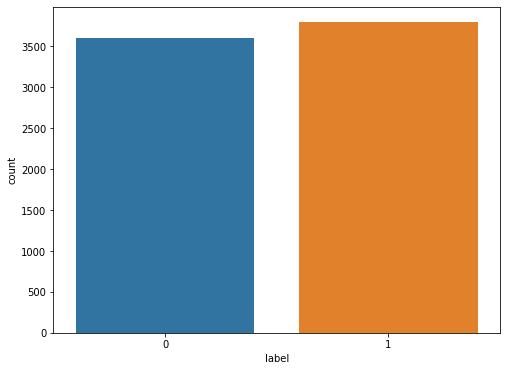

In [38]:
 # Lets check for imbalanced dataset
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.countplot(df_train.label)

In [40]:
df_train.isnull().sum()

url                               0
urlid                             0
boilerplate                       0
alchemy_category                  0
alchemy_category_score            0
avglinksize                       0
commonlinkratio_1                 0
commonlinkratio_2                 0
commonlinkratio_3                 0
commonlinkratio_4                 0
compression_ratio                 0
embed_ratio                       0
framebased                        0
frameTagRatio                     0
hasDomainLink                     0
html_ratio                        0
image_ratio                       0
is_news                           0
lengthyLinkDomain                 0
linkwordscore                     0
news_front_page                   0
non_markup_alphanum_characters    0
numberOfLinks                     0
numwords_in_url                   0
parametrizedLinkRatio             0
spelling_errors_ratio             0
label                             0
dtype: int64

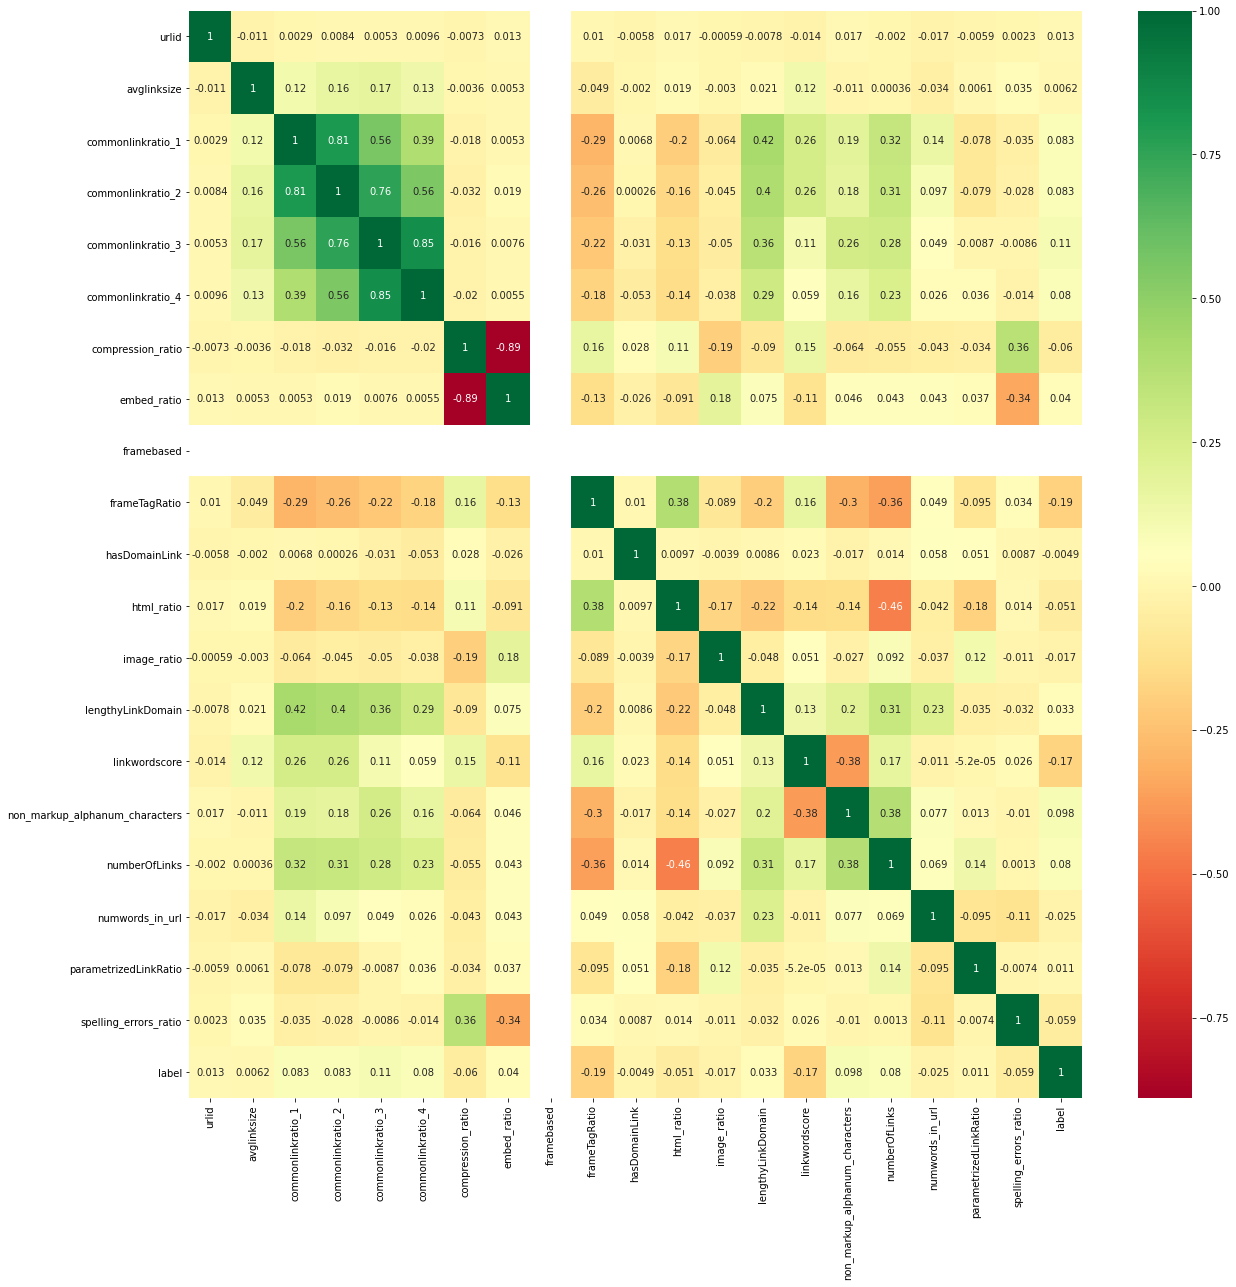

In [ ]:
corrmat = df_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
df_train['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_train['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)
 
df_train['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_train['boilerplate']=df_train['boilerplate'].str.lower()
 
 
#Cleaning the test dataframe 
 
df_test['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_test['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)
 
df_test['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_test['boilerplate']=df_test['boilerplate'].str.lower()

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 2.0MB/s 
     |████████████████████████████████| 3.2MB 2.1MB/s 
     |████████████████████████████████| 890kB 3.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=04141e84a06ff7b2e17ac9f0d4b5e6e793e38db8b4cfdc526cf7de3907766d46
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
 from transformers import AutoTokenizer, TFAutoModel
 
 
#Downloading the tokenizer and the Albert model for fine tuning
 
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert=TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
 #ADD all the variable for the Transformer model 
# because bert base uncased Model can only handle upto 512 tokens at a time
SEQ_length=512
 
#Lets create the X and Y matrix from the Df train set 
 
Xids=np.zeros((df_train.shape[0],SEQ_length))
Xmask=np.zeros((df_train.shape[0],SEQ_length))
y=np.zeros((df_train.shape[0],1))
 
#Preparing the test dataframe
 
Xids_test=np.zeros((df_test.shape[0],SEQ_length))
Xmask_test=np.zeros((df_test.shape[0],SEQ_length))
Xids

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
 for i,sequence in enumerate(df_train['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids[i,:],Xmask[i,:],y[i,0]=tokens['input_ids'],tokens['attention_mask'],df_train.loc[i,'label']
    
 
for i,sequence in enumerate(df_test['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids_test[i,:],Xmask_test[i,:]=tokens['input_ids'],tokens['attention_mask']

In [ ]:
 tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
 dataset=tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))
 
def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask},labels
 
dataset=dataset.map(map_func)
dataset=dataset.shuffle(100000).batch(64).prefetch(1000)
 
DS_size=len(list(dataset))
 
 
train=dataset.take(round(DS_size*0.90))
val=dataset.skip(round(DS_size*0.90))

In [ ]:
 #Preparing the test dataset
 
dataset_test=tf.data.Dataset.from_tensor_slices((Xids_test,Xmask_test))
 
def map_func(input_ids,mask):
    return {'input_ids':input_ids,'attention_mask':mask}
 
dataset_test=dataset_test.map(map_func)
dataset_test=dataset_test.batch(64).prefetch(1000)

In [ ]:
 from transformers import TFDistilBertModel, DistilBertConfig
distil_bert = 'distilbert-base-uncased'
 
config = DistilBertConfig(dropout=0.4, attention_dropout=0.4)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)
 
input_ids_in = tf.keras.layers.Input(shape=(SEQ_length,), name='input_ids', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(SEQ_length,), name='attention_mask', dtype='int32') 
 
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)
 
for layer in model.layers[:3]:
  layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
 model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512, 200)     695200      tf_distil_bert_model[0][0]   

In [ ]:
 model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
])

In [ ]:
 history=model.fit(train,validation_data=val,epochs=10)

Epoch 1/10
104/104 [==============================] - 506s 5s/step - loss: 0.5771 - auc: 0.7556 - precision: 0.7017 - recall: 0.7069 - val_loss: 0.4521 - val_auc: 0.8709 - val_precision: 0.8626 - val_recall: 0.7200
Epoch 2/10
104/104 [==============================] - 495s 5s/step - loss: 0.4821 - auc: 0.8505 - precision: 0.8268 - recall: 0.7575 - val_loss: 0.4199 - val_auc: 0.8967 - val_precision: 0.8405 - val_recall: 0.8120
Epoch 3/10
104/104 [==============================] - 490s 5s/step - loss: 0.4706 - auc: 0.8558 - precision: 0.8342 - recall: 0.7563 - val_loss: 0.4231 - val_auc: 0.8939 - val_precision: 0.8123 - val_recall: 0.8635
Epoch 4/10
104/104 [==============================] - 493s 5s/step - loss: 0.4451 - auc: 0.8735 - precision: 0.8391 - recall: 0.7792 - val_loss: 0.4276 - val_auc: 0.8888 - val_precision: 0.8333 - val_recall: 0.7995
Epoch 5/10
104/104 [==============================] - 498s 5s/step - loss: 0.4514 - auc: 0.8697 - precision: 0.8308 - recall: 0.7731 - val_l

In [ ]:
 predictions=model.predict(dataset_test)
df_test['label']=predictions
 
df_test.to_csv('submission.csv',columns=['urlid','label'],index=False)

In [ ]:
 input_x=tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))
 
def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask}
 
input_x=input_x.map(map_func)
input_x=input_x.shuffle(100000).batch(32).prefetch(1000)
 
y_true= y
y_true

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]])

In [42]:
y_pred=model.predict(dataset)
y_pred
 
 
y_pred = (y_pred>0.5)
y_pred
 
 
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.49      0.52      0.51      3599
         1.0       0.52      0.49      0.50      3796

    accuracy                           0.51      7395
   macro avg       0.51      0.51      0.51      7395
weighted avg       0.51      0.51      0.51      7395

